### Reproduce 

In [1]:
# torch related modules and libraries
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn

# other
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# custom modules and libraries
from context import LocalLearning

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [114]:
# PARAMETERS
eps0=4e-2    # learning rate
Kx=10
Ky=10
#hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
hid = 2000
mu=0.0
sigma=1.0
#sigma=0.2
Nep=1000      # number of epochs
Num=100      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
p=2.0        # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2

In [4]:
# Load MNIST data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('mnist_all.mat')

Nc=10
N=784
Ns=60000
M=np.zeros((0,N), dtype=np.double)
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

In [9]:
from torch import nn
from torch import Tensor, DoubleTensor
import math

class KHL3(nn.Module):
    """
    Krotov and Hopfield's (KH) Local Learning Layer (L3)
    as first implemented by Konstantin Holzhausen
    CAREFUL - definition of g does not matches any of the ones mentioned in the paper
    """

    pSet = {
        "in_size": 28 ** 2,
        "hidden_size": 2000,
        "n": 4.5,
        "p": 3,
        "lambda": 1e-2,
        "k": 7,
        "Delta": 0.4,
        "R": 1.0,
    }

    def __init__(self, params: dict):
        super(KHL3, self).__init__()

        self.pSet["in_size"] = params["in_size"]
        self.pSet["hidden_size"] = params["hidden_size"]
        self.pSet["n"] = params["n"]  # not used in this class, but belongs to the model
        self.pSet["p"] = params["p"]
        self.pSet["lambda"] = params["lambda"]
        self.pSet["k"] = params["k"]
        self.pSet["Delta"] = params["Delta"]
        self.pSet["R"] = params["R"]

        self.flatten = nn.Flatten()
        self.flatten.requires_grad_(False)
        #  initialize weights
        self.W = nn.Parameter(
            torch.zeros((self.pSet["in_size"], self.pSet["hidden_size"]), dtype=torch.double),
            requires_grad=False,
        )
        # self.W = nn.Parameter(self.W) # W is a model parameter
        std = 1.0 / math.sqrt(self.pSet["in_size"] + self.pSet["hidden_size"])
        self.W.normal_(mean=0.0, std=std)
        self.W.type(torch.double)

    def __metric_tensor(self):
        eta = torch.abs(self.W)
        return torch.pow(eta, self.pSet["p"] - 2.0)

    def _bracket(self, v: Tensor, M: Tensor) -> Tensor:
        res = torch.mul(M, self.__metric_tensor())
        return torch.matmul(v, res)

    def __matrix_bracket(self, M_1: Tensor, M_2: Tensor) -> Tensor:
        res = torch.mul(M_1, self.__metric_tensor())
        res = torch.mul(M_2, res)
        return torch.sum(res, dim=0)

    def __g(self, q: Tensor) -> Tensor:
        g_q = torch.zeros(q.size(), device=self.W.device, dtype=self.W.dtype)
        _, sorted_idxs = q.topk(self.pSet["k"], dim=-1)
        batch_size = g_q.size(dim=0)
        g_q[range(batch_size), sorted_idxs[:, 0]] = 1.0
        g_q[range(batch_size), sorted_idxs[:, 1:]] = -self.pSet["Delta"]
        return g_q

    def __weight_increment(self, v: Tensor) -> Tensor:
        h = self._bracket(v, self.W)
        Q = torch.pow(
            self.__matrix_bracket(self.W, self.W),
            (self.pSet["p"] - 1.0) / self.pSet["p"],
        )
        Q = torch.div(h, Q)
        inc = (self.pSet["R"] ** self.pSet["p"]) * v[..., None] - torch.mul(
            h[:, None, ...], self.W
        )
        return torch.mul(self.__g(Q)[:, None, ...], inc).sum(dim=0)

    def forward(self, x):
        x_flat = self.flatten(x)
        return self._bracket(x_flat, self.W)

    def param_dict(self) -> dict:
        return self.pSet

    def eval(self) -> None:
        pass

    def train(self, mode: bool = True) -> None:
        pass

    def train_step(self, x: Tensor) -> None:
        # mean training, treating each mini batch as a sample:
        # dW = self.__weight_increment(x) / self.params.tau_l
        # dW_mean = torch.sum(dW, dim=0) / dW.size(dim=0)
        # self.W += dW_mean

        # sequential training in mini batch time:
        x_flat = self.flatten(x)
        for v in x_flat:
            v = v[None, ...]  # single element -> minibatch of size 1
            self.W += self.pSet["lambda"]*self.__weight_increment(v)


class FKHL3(KHL3):
    """
    Fast AI implementation (F) of KHL3
    """

    def __init__(self, params: dict):
        super(FKHL3, self).__init__(params)

    # redefining the relevant routines to make them fast
    # "fast" means that it allows for parallel mini-batch processing

    def _g(self, q: Tensor) -> Tensor:
        g_q = torch.zeros(q.size(), device=self.W.device, dtype=self.W.dtype)
        _, sorted_idxs = q.topk(self.pSet["k"], dim=-1)
        batch_size = g_q.size(dim=0)
        g_q[range(batch_size), sorted_idxs[:, 0]] = 1.0
        g_q[range(batch_size), sorted_idxs[:, -1]] = -self.pSet["Delta"]
        return g_q

    def weight_increment(self, v: Tensor) -> Tensor:
        h = self._bracket(v, self.W)
        g_mu = self._g(h)
        inc = self.pSet["R"] ** self.pSet["p"] * (v.T @ g_mu)
        return inc - (g_mu * h).sum(dim=0)[None, ...] * self.W

    def train_step_fast(self, x: Tensor, prec=1e-4) -> None:
        # implementation of the fast unsupervised
        # training algorithm
        # it is fast because it does not require sequential training over
        # minibatch

        x_flat = self.flatten(x)
        dW = self.weight_increment(x_flat)
        nc = max(dW.abs().max(), prec)
        self.W += self.pSet["lambda"]*dW / nc

In [6]:
if torch.cuda.is_available():
    dev = torch.device('cuda')
    print(f"Cuda available, choose device: {dev}")
else:
    dev = torch.device('cpu')
    print(f"Cuda unavailable, choose device: {dev}")

Cuda available, choose device: cuda


In [78]:
train_data = datasets.MNIST(
    root="../data/MNIST",
    train=True, 
    transform=ToTensor()
)

train_dataloader = DataLoader(
    train_data,
    batch_size=100,
    num_workers=4,
    shuffle=True
)

In [116]:
llPSet = LocalLearning.FKHL3.pSet
llPSet["hidden_size"]= hid
model = LocalLearning.FKHL3(llPSet)
synapses = np.random.normal(mu, sigma, (hid, N)).astype(np.double)
#norm_synapses = synapses / (((np.absolute(synapses)**model.pSet["p"]).sum(axis=0))**(1 / model.pSet["p"]))[None, :]
model.W = nn.Parameter(torch.Tensor(synapses).T)
model.pSet["R"] = 1.0

W_lp = []
model.to(dev)

with torch.no_grad():
    for nep in tqdm(range(Nep)):
        eps=eps0*(1-nep/Nep)
        model.pSet["tau_l"] = 1 / eps
        #M=M[np.random.permutation(Ns),:]
        for batch, (features, labels) in enumerate(train_dataloader):
        #for i in range(Ns // Num):
            #model.train_step_fast(torch.Tensor(M[i*Num:(i+1)*Num,:]).to(dev))
            model.train_step_fast(features.to(dev))
            
        F_norm = torch.pow(torch.abs(model.W), model.pSet["p"]).sum(dim=0)
        W_lp.append(F_norm.mean().detach().cpu().numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:21<00:00,  1.16s/it]


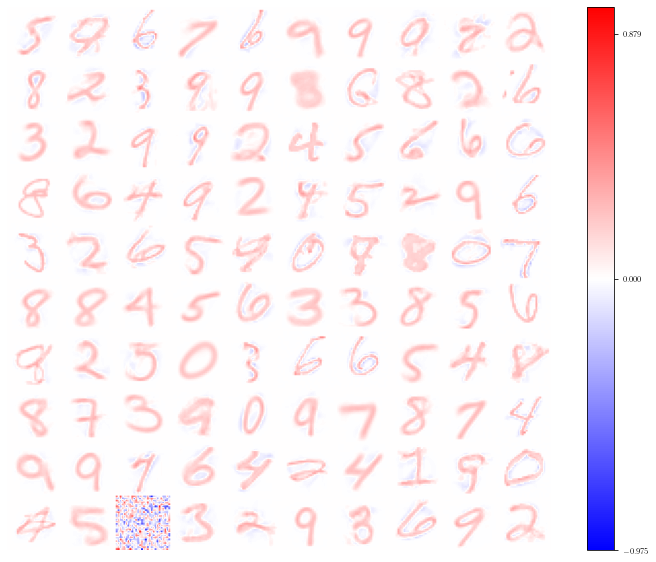

In [118]:
W = model.W.detach().cpu().clone().numpy()
W = W.T
W = W[np.random.choice(W.shape[0], Kx*Ky, replace=False)]

fig, ax = plt.subplots(figsize=(12.9, 10))
yy=0
HM=np.zeros((28*Ky,28*Kx))
for y in range(Ky):
    for x in range(Kx):
        HM[y*28:(y+1)*28,x*28:(x+1)*28]=W[yy,:].reshape(28,28)
        yy += 1
#plt.clf()
nc=np.amax(np.absolute(HM))
im=ax.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
ax.axis('off')
fig.show()

In [49]:
W.len(dim=0)

AttributeError: 'numpy.ndarray' object has no attribute 'len'

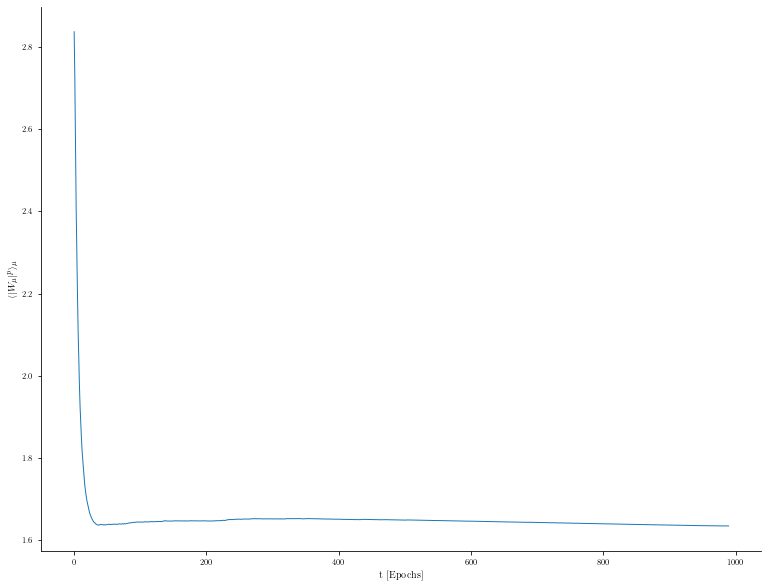

In [119]:
fig, ax = plt.subplots(figsize=(12.9, 10))
ax.plot(np.array(W_lp)[10:])
ax.set_xlabel(r"t [Epochs]")
ax.set_ylabel(r"$\langle |W_{\mu}|^{p} \rangle_{\mu}$")
fig.show()

# test_data = datasets.MNIST(
    root="../data/MNIST",
    train=False, 
    transform=ToTensor()
)

test_dataloader = DataLoader(
    test_data,
    batch_size=1000,
    num_workers=4,
    shuffle=False
)

In [84]:
model.eval()
l_n = LocalLearning.cov_spectrum(test_dataloader, model, dev)
l_n = l_n.detach().cpu().numpy()

Calculating covariance spectrum: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.24batch/s]


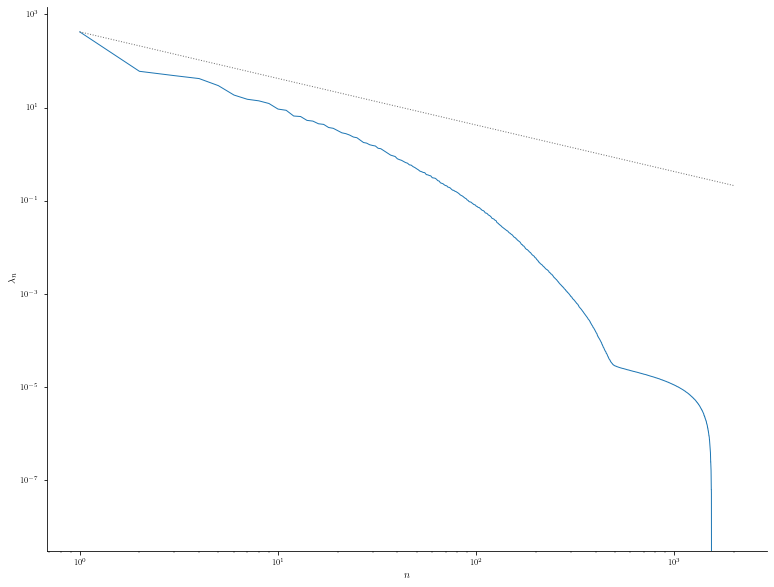

In [86]:
n = np.arange(l_n.size) + 1

fig, ax = plt.subplots(figsize=(12.9, 10.0))
ax.loglog(n, l_n)
ax.loglog(n, l_n[0] / n, color="#707070", linestyle="dotted")

ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lambda_{n}$")
fig.show()

{'in_size': 784,
 'hidden_size': 2000,
 'n': 4.5,
 'p': 3,
 'tau_l': 2499.9999999999977,
 'k': 7,
 'Delta': 0.4,
 'R': 1.0}

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [120]:
range(1, 5+1)

range(1, 6)